In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, GaussianNoise, Bidirectional, Attention, MultiHeadAttention
from tensorflow.keras.optimizers import Adam, Nadam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
from scipy.ndimage import uniform_filter1d
from functools import partial
import tensorflow as tf
import numpy as np
import os
import builtins

2025-01-21 18:26:50.198494: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set intra-op threads (for parallelizing within a single operation)
tf.config.threading.set_intra_op_parallelism_threads(24)  # Use all 24 threads

# Set inter-op threads (for parallelizing across independent operations)
tf.config.threading.set_inter_op_parallelism_threads(2)   # Adjust based on your workload

# Verify the settings
print("Intra-op threads:", tf.config.threading.get_intra_op_parallelism_threads())
print("Inter-op threads:", tf.config.threading.get_inter_op_parallelism_threads())

Intra-op threads: 24
Inter-op threads: 2


In [3]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'  # Enable oneDNN optimizations

In [4]:
# Output path
output_path = '../export/rnn/'

In [5]:
%run "../helpers/data-processing.ipynb"

Missing values in the dataset


,Column,Missing Count,Missing Percentage,Action
0,date,0,0.000000,No Missing Values
1,open,0,0.000000,No Missing Values
2,high,0,0.000000,No Missing Values
3,low,0,0.000000,No Missing Values
4,close,0,0.000000,No Missing Values
5,Volume USDT,0,0.000000,No Missing Values
6,tradecount,0,0.000000,No Missing Values
7,ema_5,0,0.000000,No Missing Values
8,ema_15,0,0.000000,No Missing Values
9,ema_30,0,0.000000,No Missing Values


Analyzing feature correlations...

The following features were dropped due to high correlation (threshold: 90%):
- HMA
- WMA
- MACD_Hist
- KAMA
- high
- ema_15
- Z-Score
- low
- close
- ema_100
- ema_60
- open
- ema_5
- ema_200
- ema_30

Performing feature selection using RandomForestClassifier...

Cross-validation accuracy scores: [0.99988 1.      1.     ]

Mean accuracy: 1.0000

The following features were selected based on feature importance:
- date
- price
- Volume USDT
- tradecount
- MACD
- MACD_Signal
- ATR
- CMO
- QStick
- price_change_ratio
- high_low_spread

Feature selection process completed.

Shape of X: (1997210, 11)


,date,price,Volume USDT,tradecount,MACD,MACD_Signal,ATR,CMO,QStick,price_change_ratio,high_low_spread
0,1.577837e+09,7180.720,509146.0,140.0,0.728704,-0.152219,4.684925,4.193879,0.120,0.000000,3.69
1,1.577837e+09,7178.470,713540.0,148.0,0.736887,-0.182091,4.698380,0.859360,0.528,-0.000313,3.76
2,1.577837e+09,7179.440,497793.0,104.0,0.846578,-0.117923,4.609025,11.466626,0.493,0.000135,5.60
3,1.577837e+09,7177.175,698627.0,193.0,0.650488,-0.343494,4.398181,-7.962104,-0.425,-0.000315,6.16
4,1.577837e+09,7175.160,241980.0,124.0,0.987398,-0.092457,4.262656,-6.795307,-0.131,-0.000281,3.86
...,...,...,...,...,...,...,...,...,...,...,...
1997205,1.698019e+09,29966.285,482950.0,635.0,-4056.925846,-1909.922487,926.278065,-97.689989,13.189,-0.000401,5.00
1997206,1.698019e+09,29970.500,169682.0,450.0,-3657.565528,-1988.042791,996.882531,-97.688910,24.399,0.000141,5.83
1997207,1.698019e+09,29975.100,111271.0,303.0,-3095.229187,-1922.717147,1072.856572,-97.688328,32.045,0.000153,3.40
1997208,1.698019e+09,29980.890,169741.0,631.0,-2332.807178,-1640.974425,1154.492462,-97.687019,22.669,0.000193,8.21



Shape of y: (1997210,)


0    1
1    0
2    1
3    0
4    0
Name: price_direction, dtype: int64

In [6]:
# Enhanced loss function with directional profit incentive
def trading_loss(prices):
    def loss_fn(y_true, y_pred):
        # Base binary crossentropy
        bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        # Enhanced profit incentive
        direction_correct = tf.sign((y_pred - 0.5) * (y_true - 0.5))
        profit_multiplier = tf.abs(y_pred - 0.5) * 2  # 0-1 range
        profit_term = direction_correct * profit_multiplier * prices
        profit_reward = -0.3 * tf.reduce_mean(profit_term)  # Increased from 0.2 to 0.3

        # Confidence penalty adjusted
        confidence_penalty = 0.005 * tf.reduce_mean(tf.square(y_pred - 0.5))  # Reduced from 0.01

        return tf.reduce_mean(bce_loss + profit_reward + confidence_penalty)
    return loss_fn

In [7]:
# Exclude date feature
X = X[:, 1:]

In [8]:
# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Reserve the last 15% as the test set
test_size = int(0.15 * len(X_scaled))
X_test, y_test = X_scaled[-test_size:], y[-test_size:]
X_train_val, y_train_val = X_scaled[:-test_size], y[:-test_size]

In [10]:
# Reshape data for LSTM input: (samples, time_steps, features)
time_steps = 30  # Number of past time steps to use for prediction
X_train_val = np.array([X_train_val[i:i + time_steps] for i in range(len(X_train_val) - time_steps)])
y_train_val = y_train_val[time_steps:]
X_test = np.array([X_test[i:i + time_steps] for i in range(len(X_test) - time_steps)])
y_test = y_test[time_steps:]

In [11]:
# Time-based split using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
# Placeholder to store metrics for each split
split_metrics = []

for i, (train_idx, val_idx) in enumerate(tscv.split(X_train_val)):
    print(f"\nSplit {i + 1}/{tscv.n_splits}")

    # Split the data
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    # Align prices for this split
    prices_train = prices[time_steps:time_steps + len(X_train)]
    prices_val = prices[time_steps + len(X_train):time_steps + len(X_train) + len(X_val)]

    # Balance the classes
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Build the RNN model
    model = Sequential([
        Input(shape=(time_steps, X_train.shape[2])),
        Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
        GaussianNoise(0.02),  # Added input noise
        Dropout(0.4),  # Increased from 0.3
        BatchNormalization(),
        Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))),
        Dropout(0.35),  # Adjusted from 0.3
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Modify optimizer settings
    optimizer = AdamW(learning_rate=0.0001,  # Increased from 0.00005
                      weight_decay=1e-4,  # Increased regularization
                      clipnorm=1.0)  # Added gradient clipping

    # Compile the model
    model.compile(
        optimizer = optimizer,
        loss=trading_loss(prices_train),
        metrics=['accuracy']
    )

    # Early stopping and learning rate scheduler to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


    # Train the model with class weights
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=256,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy for Split {i + 1}: {val_accuracy:.4f}")
    print(f"Validation Loss for Split {i + 1}: {val_loss:.4f}")

    # Save metrics for analysis
    split_metrics.append({
        "split": i + 1,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
    })


Split 1/5
Epoch 1/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 382s 343ms/step - accuracy: 0.6363 - loss: -580.9387 - val_accuracy: 0.6850 - val_loss: -917.1485 - learning_rate: 1.0000e-04
Epoch 2/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 391s 354ms/step - accuracy: 0.7212 - loss: -1083.5035 - val_accuracy: 0.6977 - val_loss: -993.4938 - learning_rate: 1.0000e-04
Epoch 3/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 381s 345ms/step - accuracy: 0.7422 - loss: -1209.2341 - val_accuracy: 0.7072 - val_loss: -1046.5178 - learning_rate: 1.0000e-04
Epoch 4/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 395s 357ms/step - accuracy: 0.7582 - loss: -1295.0199 - val_accuracy: 0.7156 - val_loss: -1090.0415 - learning_rate: 1.0000e-04
Epoch 5/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 419s 379ms/step - accuracy: 0.7693 - loss: -1356.7241 - val_accuracy: 0.7217 - val_loss: -1121.0856 - learning_rate: 1.0000e-04
Epoch 6/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 439s 397ms/step - accuracy: 0.7794 - loss: -1411.3363 - val_accuracy: 0.7310 - val_loss: -1168.6016 

KeyboardInterrupt: 

In [13]:
# Aggregate results across splits
mean_val_accuracy = np.mean([m["val_accuracy"] for m in split_metrics])
mean_val_loss = np.mean([m["val_loss"] for m in split_metrics])

print("\n--- Cross-Validation Results ---")
print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f}")
print(f"Mean Validation Loss: {mean_val_loss:.4f}")


--- Cross-Validation Results ---
Mean Validation Accuracy: 0.8074
Mean Validation Loss: -2904.1416


In [14]:
# Prepare test dataset and evaluation variables
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
X_test_evaluate = X_test  # Assign X_test for evaluation
y_test_evaluate = y_test  # Assign y_test for evaluation

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.82


In [17]:
# Predict probabilities for the entire test set
predicted_probas = model.predict(X_test).flatten()

9361/9361 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step


In [18]:
# Smooth predicted probabilities
smoothed_probas = uniform_filter1d(predicted_probas, size=5)

In [19]:
print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (1131733, 30, 10) (1131733,)
Validation set size: (282933, 30, 10) (282933,)
Test set size: (299551, 30, 10) (299551,)


In [20]:
# Slice prices to match each split
prices_train = prices[time_steps:time_steps + len(X_train)]  # Prices corresponding to training data
prices_val = prices[time_steps + len(X_train):time_steps + len(X_train) + len(X_val)]  # Validation prices
prices_test = prices[-len(X_test):]  # Remaining prices for test set

In [21]:
# Adjusted thresholds
# buy_threshold = 0.8
# sell_threshold = 0.2

# Adjust thresholds based on validation data
buy_threshold = np.percentile(predicted_probas, 90)  # Try top 10%
sell_threshold = np.percentile(predicted_probas, 10)  # Try bottom 10%

print(f"Dynamic Buy Threshold: {buy_threshold}")
print(f"Dynamic Sell Threshold: {sell_threshold}")

Dynamic Buy Threshold: 1.0
Dynamic Sell Threshold: 7.337645913483521e-17


In [22]:
# Maximum fraction of the portfolio to trade
max_trade_fraction = 0.1  # up to 10% in the most confident case

In [23]:
# Minimum confidence required to trade
min_confidence = 0.3

2341/2341 ━━━━━━━━━━━━━━━━━━━━ 357s 152ms/step - accuracy: 0.8322 - loss: -5971.2979
Test Accuracy: 82.36%
9361/9361 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step
Confusion Matrix:
Predicted       0
Actual           
0          146590
1          152961


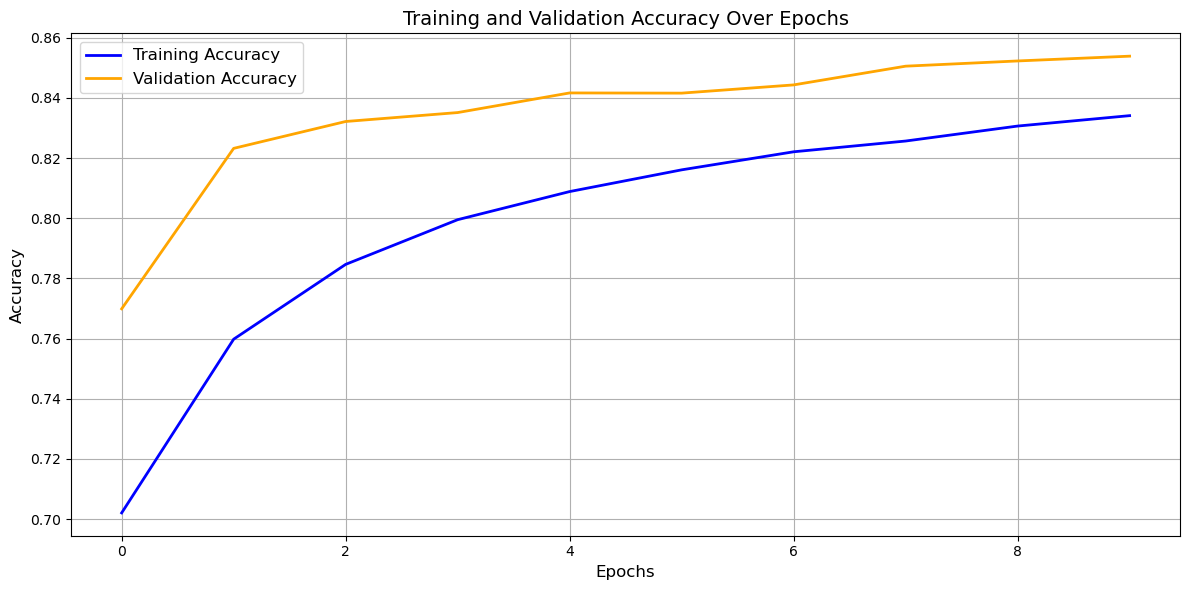

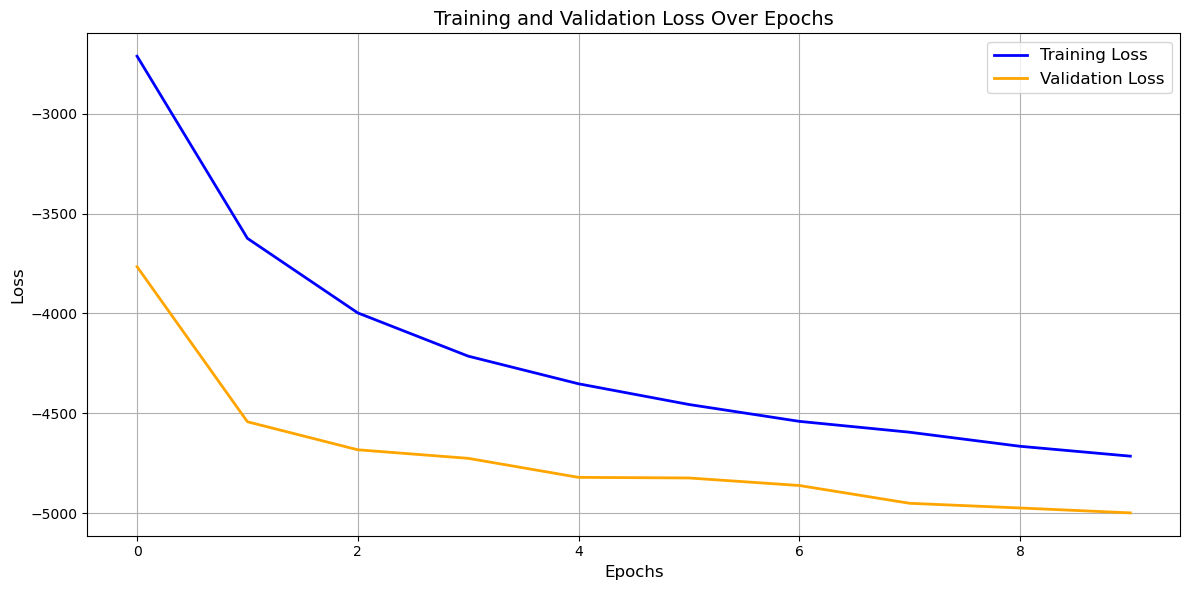

In [24]:
%run "../helpers/evaluate_tf.ipynb"

In [25]:
# Starting portfolio values
usd_balance = 10000.0  # Starting USD balance
btc_balance = 0.0      # Starting BTC balance
buy_fee = 0.0025  # 0.25% buy fee
sell_fee = 0.004  # 0.40% sell fee

# Add risk management parameters
stop_loss_pct = 0.97  # 3% stop loss
take_profit_pct = 1.05  # 5% take profit
max_position_size = 0.25  # 25% of portfolio

# Add variables to track short positions
btc_shorted = 0.0  # Amount of BTC borrowed for short selling
short_entry_price = 0.0  # Price at which short position was opened

# Track balances and actions
usd_balances = []
btc_balances = []
actions = []
trade_percentages = []

# --- Initialize Trade Counters ---
buy_count = 0
sell_count = 0
short_count = 0
stop_loss_count = 0
take_profit_count = 0

# --- Initialize Trading Data for Plotting ---
trading_data = pd.DataFrame({
    'prices': prices_test,
    'Action': ['None'] * len(prices_test),
    'USD Balance': [0.0] * len(prices_test),
    'BTC Balance': [0.0] * len(prices_test),
    'Total Portfolio Value': [0.0] * len(prices_test)
})

# --- Initialize Balance Histories for Plotting ---
total_capital_history = []
usd_balance_history = []
btc_balance_history = []

In [26]:
# Loop over prices_test and use precomputed probabilities
for t in range(len(prices_test)):
    # Default action is 'None'
    action = 'None'
    trade_percentage = 0.0

    # Use precomputed probability
    predicted_proba = smoothed_probas[t]

    # Compute confidence: ranges from 0 (proba = 0.5) to 0.5 (proba = 0 or 1)
    confidence = abs(predicted_proba - 0.5)  # 0.0 → not sure, 0.5 → extremely sure

    # Current price
    current_price = prices_test[t]

    # Check exit conditions first
    if btc_balance > 0:
        # Check stop loss or take profit
        current_value = btc_balance * current_price
        if current_value <= entry_value * stop_loss_pct:
            # Execute stop loss
            usd_balance += current_value * (1 - sell_fee)
            btc_balance = 0
            action = 'StopLoss (Long)'
            stop_loss_count += 1
        elif current_value >= entry_value * take_profit_pct:
            # Execute take profit
            usd_balance += current_value * (1 - sell_fee)
            btc_balance = 0
            action = 'TakeProfit (Long)'
            take_profit_count += 1

    # Check exit conditions for short positions
    if btc_shorted > 0:
        current_short_value = btc_shorted * current_price
        if current_short_value >= short_entry_value * stop_loss_pct:
            # Execute stop loss for short position
            usd_balance -= current_short_value * (1 + buy_fee)  # Buy back BTC to cover short
            btc_shorted = 0
            action = 'StopLoss (Short)'
            stop_loss_count += 1
        elif current_short_value <= short_entry_value * take_profit_pct:
            # Execute take profit for short position
            usd_balance -= current_short_value * (1 + buy_fee)  # Buy back BTC to cover short
            btc_shorted = 0
            action = 'TakeProfit (Short)'
            take_profit_count += 1

    if confidence > min_confidence and btc_balance == 0:
        # Turn confidence into a fraction of max_trade_fraction
        # e.g. if confidence=0.4, fraction_to_trade=0.2*(0.4/0.5)=0.16 (i.e. 16% of USD)
        fraction_to_trade = min(max_trade_fraction * (confidence / 0.5), max_position_size)

        # Long Entry (Buy)
        if predicted_proba > buy_threshold and usd_balance > 1e-3:
            # Buy if proba > buy_threshold. The fraction_to_trade goes from 0 to max_trade_fraction (0 to 20%)
            usd_spent = fraction_to_trade * usd_balance
            # Convert to BTC, minus the buy fee
            btc_bought = (usd_spent * (1 - buy_fee)) / current_price
            usd_balance -= usd_spent
            btc_balance += btc_bought
            entry_value = btc_balance * current_price  # Track entry value
            action = 'Buy'
            trade_percentage = fraction_to_trade  # record how much fraction we traded
            buy_count += 1

        # Short Entry (Sell)
        elif predicted_proba < sell_threshold and usd_balance > 1e-3 and btc_balance == 0:
            # Borrow BTC to sell short
            btc_shorted = fraction_to_trade * (usd_balance / current_price)
            usd_balance += btc_shorted * current_price * (1 - sell_fee)  # Receive USD from short sale
            short_entry_value = btc_shorted * current_price  # Track entry value for short position
            short_entry_price = current_price  # Track entry price for short position
            action = 'Sell (Short)'
            trade_percentage = fraction_to_trade
            short_count += 1

        # Close Long Position (Sell)        
        elif predicted_proba < sell_threshold and btc_balance > 1e-6:
            # Sell if proba < sell_threshold. fraction_to_trade is again 0 to 20% based on confidence
            btc_to_sell = fraction_to_trade * btc_balance
            usd_gained = btc_to_sell * prices_test[t] * (1 - sell_fee)
            btc_balance -= btc_to_sell
            usd_balance += usd_gained
            action = 'Sell (Long)'
            trade_percentage = fraction_to_trade  # record how much fraction we traded
            sell_count += 1

    # --- Record Data for Plotting ---
    trading_data.loc[t, 'Action'] = action
    trading_data.loc[t, 'USD Balance'] = usd_balance
    trading_data.loc[t, 'BTC Balance'] = btc_balance
    trading_data.loc[t, 'Total Portfolio Value'] = usd_balance + btc_balance * current_price
    
    # Record balances and actions
    total_capital_history.append(usd_balance + btc_balance * current_price)
    usd_balance_history.append(usd_balance)
    btc_balance_history.append(btc_balance)

In [27]:
# --- Final Portfolio Status ---
final_btc_price = prices_test[-1]
remaining_btc_value = btc_balance * final_btc_price

# Close any remaining long position
if btc_balance > 0:
    final_value = btc_balance * final_btc_price * (1 - sell_fee)
    usd_balance += final_value
    btc_balance = 0

# Close any remaining short position
if btc_shorted > 0:
    final_value = btc_shorted * final_btc_price * (1 + buy_fee)
    usd_balance -= final_value
    btc_shorted = 0

# Calculate final portfolio value
total_portfolio_value = usd_balance + remaining_btc_value
profit_loss = ((total_portfolio_value - 10000) / 10000) * 100

In [28]:
# Print final portfolio status
print("Final Portfolio Status:")
print(f"  USD Balance: ${usd_balance:.2f}")
print(f"  BTC Balance: {btc_balance:.6f} BTC")
print(f"  BTC Value (in USD at last price): ${remaining_btc_value:.2f}")
print(f"  Total Portfolio Value (USD): ${total_portfolio_value:.2f}")
print(f"  Profit/Loss: {profit_loss:.2f}%")
print(f"  Total Trades Executed: {buy_count + sell_count + short_count}")
print(f"    Buy Trades: {buy_count}")
print(f"    Sell Trades: {sell_count}")
print(f"    Short Trades: {short_count}")
print(f"    Stop-Loss Triggers: {stop_loss_count}")
print(f"    Take-Profit Triggers: {take_profit_count}")

Final Portfolio Status:
  USD Balance: $3866.55
  BTC Balance: 0.000000 BTC
  BTC Value (in USD at last price): $0.00
  Total Portfolio Value (USD): $3866.55
  Profit/Loss: -61.33%
  Total Trades Executed: 1599
    Buy Trades: 0
    Sell Trades: 0
    Short Trades: 1599
    Stop-Loss Triggers: 1599
    Take-Profit Triggers: 0


In [29]:
# --- Plotting ---
import matplotlib.pyplot as plt

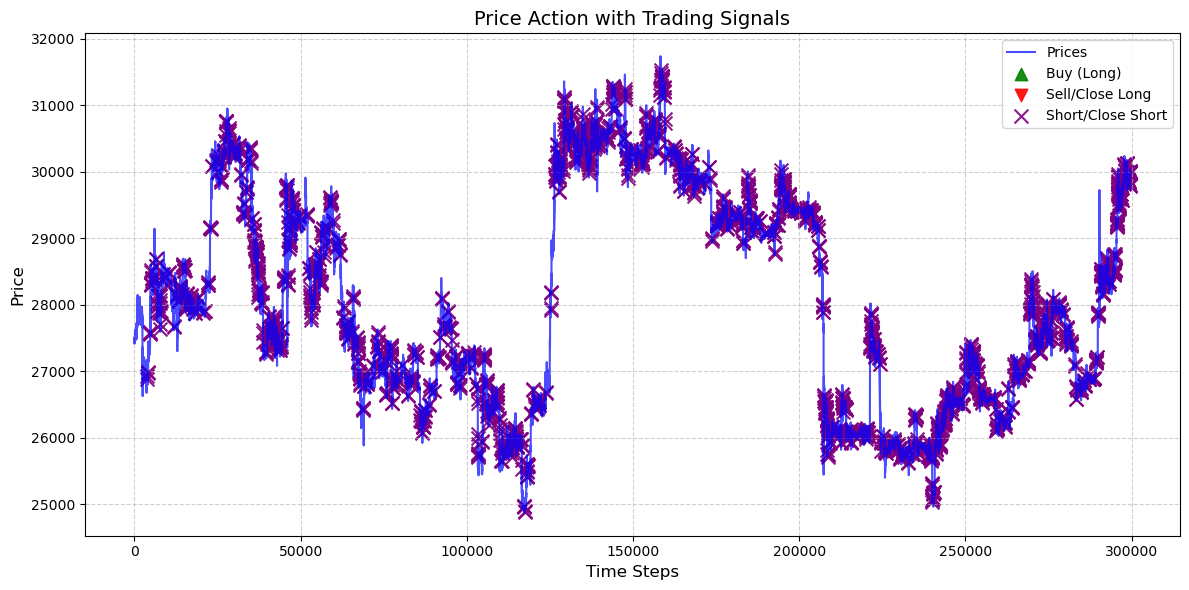

In [30]:
# Plot prices and actions
plt.figure(figsize=(12, 6))
plt.plot(trading_data['prices'], label='Prices', color='blue', alpha=0.7, linewidth=1.5)

# Highlight trade actions
buy_indices = trading_data[trading_data['Action'] == 'Buy'].index
sell_long_indices = trading_data[trading_data['Action'].isin(['Sell (Long)', 'StopLoss (Long)', 'TakeProfit (Long)'])].index
sell_short_indices = trading_data[trading_data['Action'].isin(['Sell (Short)', 'StopLoss (Short)', 'TakeProfit (Short)'])].index

plt.scatter(buy_indices, trading_data.loc[buy_indices, 'prices'],
            color='green', label='Buy (Long)', marker='^', s=80, alpha=0.9)
plt.scatter(sell_long_indices, trading_data.loc[sell_long_indices, 'prices'],
            color='red', label='Sell/Close Long', marker='v', s=80, alpha=0.9)
plt.scatter(sell_short_indices, trading_data.loc[sell_short_indices, 'prices'],
            color='purple', label='Short/Close Short', marker='x', s=100, alpha=0.9)

plt.title('Price Action with Trading Signals', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [31]:
# --- Calculate Cumulative Moving Averages ---
cumulative_average_total = pd.Series(total_capital_history).expanding(min_periods=1).mean()
cumulative_average_usd = pd.Series(usd_balance_history).expanding(min_periods=1).mean()
cumulative_average_btc = pd.Series(btc_balance_history).expanding(min_periods=1).mean()

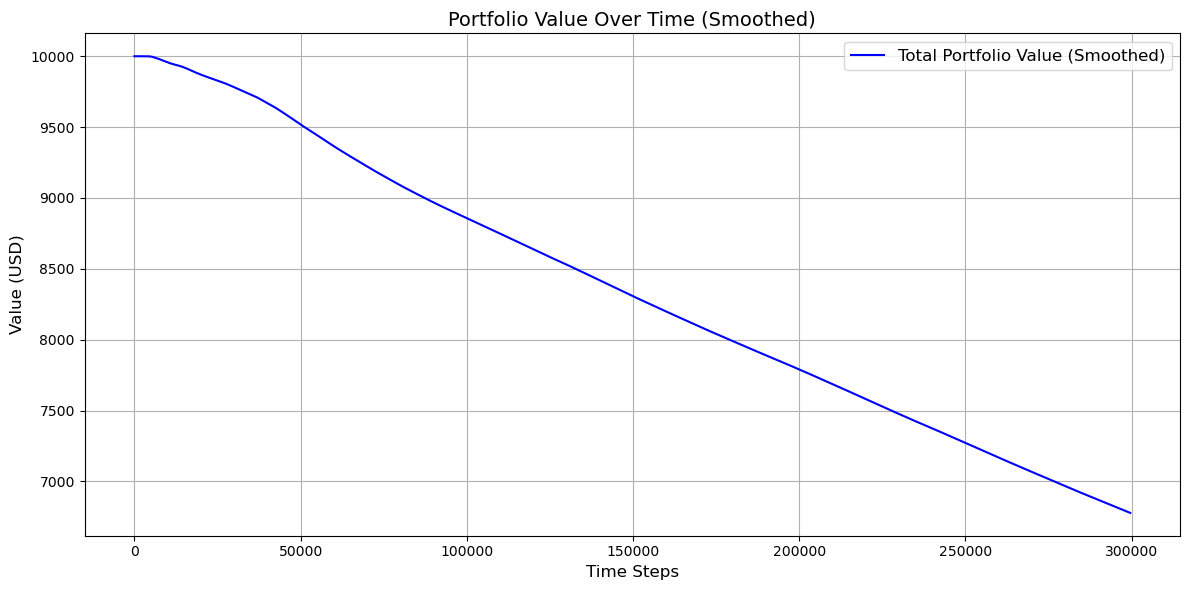

In [32]:
# --- Plot Portfolio Value Progression ---
plt.figure(figsize=(12, 6))
plt.plot(cumulative_average_total, label="Total Portfolio Value (Smoothed)", color='blue')
plt.title("Portfolio Value Over Time (Smoothed)", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Value (USD)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

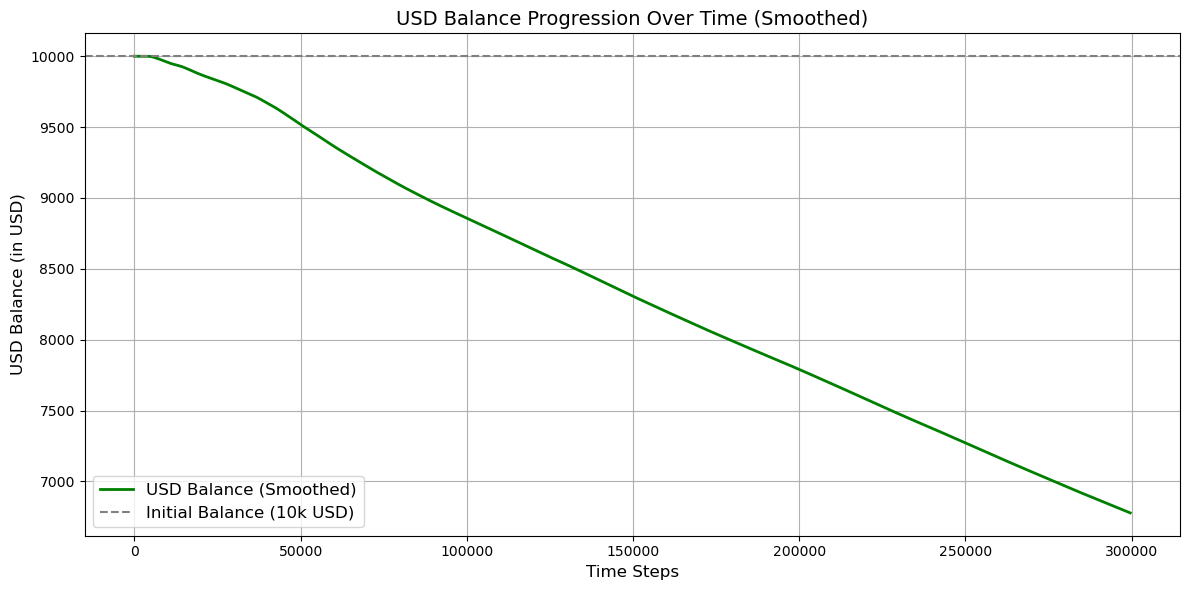

In [33]:
# --- Plot USD Balance Progression ---
plt.figure(figsize=(12, 6))
plt.plot(cumulative_average_usd, label="USD Balance (Smoothed)", color='green', linewidth=2)
plt.axhline(y=10000, color='gray', linestyle='--', label="Initial Balance (10k USD)")
plt.title("USD Balance Progression Over Time (Smoothed)", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("USD Balance (in USD)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

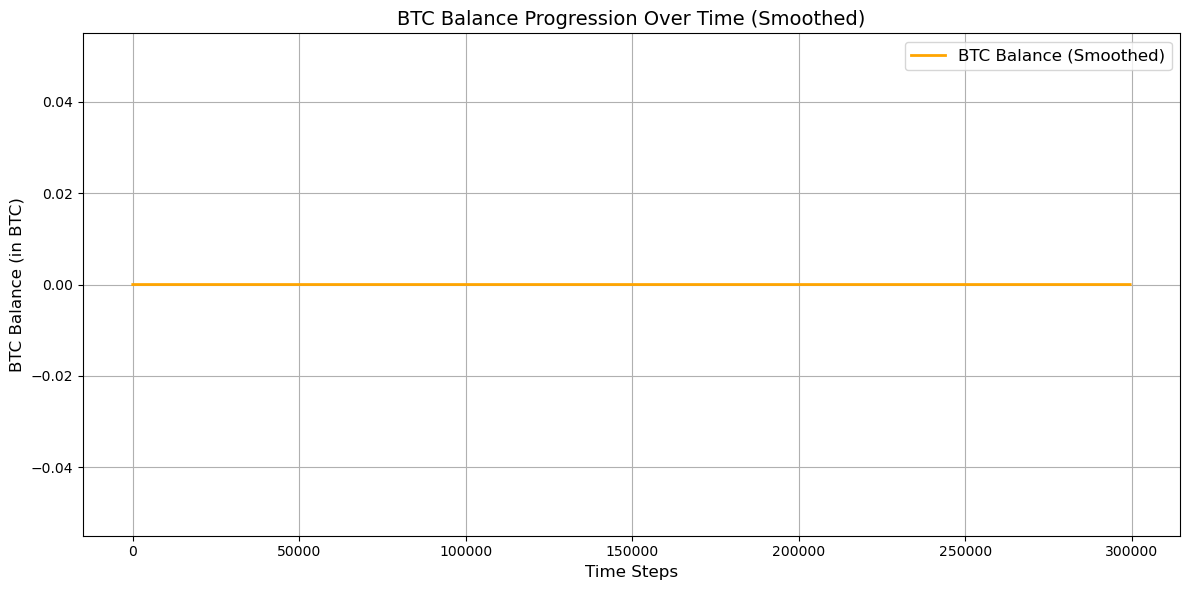

In [34]:
# --- Plot BTC Balance Progression ---
plt.figure(figsize=(12, 6))
plt.plot(cumulative_average_btc, label="BTC Balance (Smoothed)", color='orange', linewidth=2)
plt.title("BTC Balance Progression Over Time (Smoothed)", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("BTC Balance (in BTC)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Free-up memory
plt.close('all')

In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Ensure reproducibility
np.random.seed(42)

# Placeholder for your dataset (X, y)
# Replace these with your actual input_data
# X_train, X_val, X_test, y_train, y_val, y_test should already be defined

# Test set evaluation
def evaluate_on_test_set(model, X_test, y_test):
    """Evaluate the model on the test set and return metrics."""
    y_pred = model.predict(X_test)
    y_test = np.array(y_test).astype(int)
    y_pred = (y_pred > 0.5).astype(int).flatten()

    test_accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return {
        'accuracy': test_accuracy,
        'report': report,
        'confusion_matrix': cm
    }

# Confidence analysis
def analyze_prediction_confidence(model, X_test, y_test):
    """Analyze prediction confidence and return plots."""
    try:
        predicted_proba = model.predict_proba(X_test)
        confidence_scores = np.max(predicted_proba, axis=1)

        plt.figure(figsize=(10, 6))
        plt.hist(confidence_scores, bins=20, color='blue', alpha=0.7, edgecolor='black')
        plt.title("Prediction Confidence Distribution")
        plt.xlabel("Confidence")
        plt.ylabel("Frequency")
        plt.grid(alpha=0.6)
        plt.show()

        correct_predictions = (model.predict(X_test) > 0.5).astype(int).flatten() == y_test
        plt.figure(figsize=(10, 6))
        plt.scatter(confidence_scores, correct_predictions, alpha=0.3, color='orange')
        plt.title("Confidence vs Correctness")
        plt.xlabel("Confidence")
        plt.ylabel("Correct Prediction")
        plt.grid(alpha=0.6)
        plt.show()
    except AttributeError:
        print("Model does not have a predict_proba method.")

# Data leakage check
def check_data_leakage(X_train, X_test):
    """Check for input_data leakage between training and test sets."""
    if not isinstance(X_train, (pd.DataFrame, np.ndarray)) or not isinstance(X_test, (pd.DataFrame, np.ndarray)):
        print("X_train and X_test should be DataFrames or NumPy arrays for leakage check.")
        return

    # Convert to DataFrames if they are NumPy arrays
    if isinstance(X_train, np.ndarray):
        X_train = pd.DataFrame(X_train)
    if isinstance(X_test, np.ndarray):
        X_test = pd.DataFrame(X_test)

    common_features = set(X_train.columns) & set(X_test.columns)
    if len(common_features) != X_train.shape[1]:
        print("Warning: Feature mismatch between train and test sets.")
    else:
        print("No apparent input_data leakage detected in features.")

# Evaluate robustness with noisy input_data
def evaluate_with_noise(model, X_test, y_test, noise_level=0.01):
    """Evaluate model's robustness with noisy input_data and return accuracy."""
    if not isinstance(X_test, np.ndarray):
        try:
            X_test = X_test.values  # Convert to numpy array if possible
        except AttributeError:
            print("X_test cannot be converted to a numpy array.")
            return None
    X_noisy = X_test + noise_level * np.random.normal(size=X_test.shape)
    y_pred_noisy = (model.predict(X_noisy) > 0.5).astype(int).flatten()
    noisy_accuracy = accuracy_score(y_test, y_pred_noisy)
    return noisy_accuracy

# Run all checks
def check_model_overfitting(model, X_train, X_val, X_test, y_train, y_val, y_test, noise_level=0.01):
    """Run all evaluations to check for model overfitting."""
    print("\n--- Evaluating on Test Set ---")
    test_results = evaluate_on_test_set(model, X_test, y_test)
    print(f"Test Set Accuracy: {test_results['accuracy']}")
    print("Classification Report (Test Set):\n", test_results['report'])
    print("Confusion Matrix (Test Set):\n", test_results['confusion_matrix'])

    print("\n--- Analyzing Prediction Confidence ---")
    analyze_prediction_confidence(model, X_test, y_test)

    print("\n--- Checking for Data Leakage ---")
    check_data_leakage(X_train, X_test)

    print("\n--- Evaluating with Noise ---")
    noisy_accuracy = evaluate_with_noise(model, X_test, y_test, noise_level)
    print(f"Accuracy with {noise_level * 100:.1f}% Noise:", noisy_accuracy)

# Usage example (replace `model` with your trained model)
noise_level = 0.01  # Define the noise level
check_model_overfitting(model, X_train, X_val, X_test, y_train, y_val, y_test, noise_level)


--- Evaluating on Test Set ---
9361/9361 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step
Test Set Accuracy: 0.8236160119645737
Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.82      0.82      0.82    146590
           1       0.83      0.82      0.83    152961

    accuracy                           0.82    299551
   macro avg       0.82      0.82      0.82    299551
weighted avg       0.82      0.82      0.82    299551

Confusion Matrix (Test Set):
 [[120545  26045]
 [ 26791 126170]]

--- Analyzing Prediction Confidence ---
Model does not have a predict_proba method.

--- Checking for Data Leakage ---


ValueError: Must pass 2-d input. shape=(1131733, 30, 10)